In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
import time
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
import os
import zipfile

from skimage.transform import resize
from sklearn.model_selection import train_test_split

from tensorflow.python.keras.utils import np_utils
from tensorflow.python.keras.models import Sequential, Model,load_model
from tensorflow.python.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.python.keras.layers.convolutional import Conv2D, MaxPooling2D 
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.python.keras.optimizers import RMSprop, SGD
from tensorflow.python.keras.applications import VGG19, ResNet50, InceptionV3

sys.version

'3.6.7 (default, Oct 22 2018, 11:32:17) \n[GCC 8.2.0]'

In [0]:
zip_ref = zipfile.ZipFile('drive/My Drive/Colab Notebooks/image_data.zip', 'r')
zip_ref.extractall('unzipped_folder') # unzip directory
zip_ref.close()

In [0]:
# base_path = 'Dataset/flowers/'
base_path = 'unzipped_folder/train/'
# test_path = 'Dataset/test/'
test_path = 'unzipped_folder/test/'
# daisy：菊花。 dandelion：蒲公英。 rose：玫瑰。 sunflower：向日葵。 tulip：郁金香。
categories = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [0]:
fnames = []
for category in categories:
    flower_folder = os.path.join(base_path, category)
    file_names = os.listdir(flower_folder)
    full_path = [os.path.join(flower_folder, file_name) for file_name in file_names]
    fnames.append(full_path)

In [0]:
# train, test = train_test_split(fnames[0], train_size=0.8)
images = []
for names in fnames:
    one_category_images = [cv2.imread(name) for name in names if (cv2.imread(name)) is not None]
    images.append(one_category_images)

In [7]:
for i,imgs in enumerate(images):
    shapes = [img.shape for img in imgs]
    widths = [shape[0] for shape in shapes]
    heights = [shape[1] for shape in shapes]
    print('%d,%d is the min shape for %s' % (np.min(widths), np.min(heights), categories[i]))

125,134 is the min shape for daisy
104,134 is the min shape for dandelion
80,150 is the min shape for rose
134,159 is the min shape for sunflower
134,134 is the min shape for tulip


In [0]:
img_width, img_height = 256, 256

# Apply resize to all images
resized_images = []
for i,imgs in enumerate(images):
    resized_images.append([cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC) for img in imgs])

In [0]:
train_images = []
val_images = []
for imgs in resized_images:
    train, test = train_test_split(imgs, train_size=0.8, test_size=0.2)
    train_images.append(train)
    val_images.append(test)

In [10]:
len_train_images = [len(imgs) for imgs in train_images]
print(len_train_images)
print('sum of train images:', np.sum(len_train_images))
train_categories = np.zeros((np.sum(len_train_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        train_categories[:len_train_images[i]] = i
    else:
        train_categories[np.sum(len_train_images[:i]):np.sum(len_train_images[:i+1])] = i
        
len_val_images = [len(imgs) for imgs in val_images]
print(len_val_images)
print('sum of val_images:', np.sum(len_val_images))
val_categories = np.zeros((np.sum(len_val_images)), dtype='uint8')
for i in range(5):
    if i is 0:
        val_categories[:len_val_images[i]] = i
    else:
        val_categories[np.sum(len_val_images[:i]):np.sum(len_val_images[:i+1])] = i

[400, 549, 412, 390, 506]
sum of train images: 2257
[100, 138, 103, 98, 127]
sum of val_images: 566


In [0]:
tmp_train_imgs = []
tmp_val_imgs = []
for imgs in train_images:
    tmp_train_imgs += imgs
for imgs in val_images:
    tmp_val_imgs += imgs
train_images = np.array(tmp_train_imgs)
val_images = np.array(tmp_val_imgs)

train_data = train_images.astype('float32')
val_data = val_images.astype('float32')
train_labels = np_utils.to_categorical(train_categories, len(categories))
val_labels = np_utils.to_categorical(val_categories, len(categories))

In [0]:
seed = 100
np.random.seed(seed)
np.random.shuffle(train_data)
np.random.seed(seed)
np.random.shuffle(train_labels)
np.random.seed(seed)
np.random.shuffle(val_data)
np.random.seed(seed)
np.random.shuffle(val_labels)
train_data = train_data[:3400]
train_labels = train_labels[:3400]
val_data = val_data[:860]
val_labels = val_labels[:860]

In [0]:
WEIGHTS_PATH_NO_TOP = 'drive/My Drive/Colab Notebooks/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'

def create_model_from_ResNet50():

    """
     Use ResNet-50 (this model's code is from https://www.kaggle.com/cokastefan/keras-resnet-50)
    """
    model = Sequential()

    model.add(ResNet50(include_top=False, pooling='avg', weights=WEIGHTS_PATH_NO_TOP))
    model.add(Flatten())
    model.add(BatchNormalization())
    model.add(Dense(2048, activation='relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.25))
    model.add(BatchNormalization())
    model.add(Dense(len(categories), activation='softmax'))

    model.layers[0].trainable = True
    
    model.compile(loss='categorical_crossentropy', optimizer=SGD(lr=1e-3, momentum=0.90, nesterov=True), metrics=['acc']) # optimizer=(lr=0.001)
    
    return model

In [14]:
model_ResNet50 = create_model_from_ResNet50()
model_ResNet50.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_v1 (Batc (None, 2048)              8192      
_________________________________________________________________
dense (Dense)                (None, 2048)              4196352   
_________________________________________________________________
dropout (Dropout)            (None, 2048)              0         
_________________________________________________________________
batch_normalization_v

In [0]:
# Parameters
batch_size = 16
# epochs1 = 50
# epochs2 = 20
epochs3 = 40

In [0]:
# Adding rescale, rotation_range, width_shift_range, height_shift_range,
# shear_range, zoom_range, and horizontal flip to our ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.2,
    zoom_range=0.3,
    horizontal_flip=True
)

# Note that the validation data should not be augmented!
val_datagen = ImageDataGenerator(
    rescale=1./255,
#     rotation_range=40,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     shear_range=0.2,
#     zoom_range=0.2,
#     horizontal_flip=True
)

# Flow training images in batches of 32 using train_datagen generator
train_generator = train_datagen.flow(
    train_data,
    train_labels,
    batch_size=batch_size
)

val_generator = val_datagen.flow(
    val_data,
    val_labels,
    batch_size=batch_size
)

In [17]:
start = time.time()

model_ResNet50_info = model_ResNet50.fit_generator(
    generator=train_generator, 
    steps_per_epoch=len(train_data)/(batch_size),   # -> 106 # images 3392 = steps * batch_size = 106 * 32 
    epochs=epochs3, 
    validation_steps=len(val_data)/(batch_size), # -> 26 # images 832 = steps * batch_size = 26 * 32
    validation_data=val_generator, 
    verbose=1
)

end = time.time()
duration = end - start
print ('\n model_ResNet50 took %0.2f seconds (%0.1f minutes) to train for %d epochs'%(duration, duration/60, epochs3) )
model_ResNet50.save('drive/My Drive/Colab Notebooks/Models/reset_50_training_sgd02.h5')

Instructions for updating:
Use tf.cast instead.
Epoch 1/40
142/142 [==============================] - 57s 398ms/step - loss: 0.9500 - acc: 0.6752 - val_loss: 2.4158 - val_acc: 0.2438
Epoch 2/40
142/142 [==============================] - 45s 314ms/step - loss: 0.6843 - acc: 0.7789 - val_loss: 2.2766 - val_acc: 0.1820
Epoch 3/40
142/142 [==============================] - 43s 305ms/step - loss: 0.5220 - acc: 0.8316 - val_loss: 3.8282 - val_acc: 0.2420
Epoch 4/40
142/142 [==============================] - 45s 315ms/step - loss: 0.5037 - acc: 0.8272 - val_loss: 2.4489 - val_acc: 0.3534
Epoch 5/40
142/142 [==============================] - 44s 310ms/step - loss: 0.4273 - acc: 0.8573 - val_loss: 1.8149 - val_acc: 0.5477
Epoch 6/40
142/142 [==============================] - 44s 312ms/step - loss: 0.3984 - acc: 0.8684 - val_loss: 0.6439 - val_acc: 0.8180
Epoch 7/40
142/142 [==============================] - 45s 320ms/step - loss: 0.3259 - acc: 0.8870 - val_loss: 0.4187 - val_acc: 0.8940
Epoch 8

In [0]:
# Plots for training and testing process: loss and accuracy

def plot_model_history(model_name, history, epochs):
  
  print(model_name)
  plt.figure(figsize=(15, 5))
  
  # summarize history for accuracy
  plt.subplot(1, 2 ,1)
  plt.plot(np.arange(0, len(history['acc'])), history['acc'], 'r')
  plt.plot(np.arange(1, len(history['val_acc'])+1), history['val_acc'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Accuracy vs. Validation Accuracy')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Accuracy')
  plt.legend(['train', 'validation'], loc='best')
  
  plt.subplot(1, 2, 2)
  plt.plot(np.arange(1, len(history['loss'])+1), history['loss'], 'r')
  plt.plot(np.arange(1, len(history['val_loss'])+1), history['val_loss'], 'g')
  plt.xticks(np.arange(0, epochs+1, epochs/10))
  plt.title('Training Loss vs. Validation Loss')
  plt.xlabel('Num of Epochs')
  plt.ylabel('Loss')
  plt.legend(['train', 'validation'], loc='best')
  
  
  plt.show()

model_ResNet50


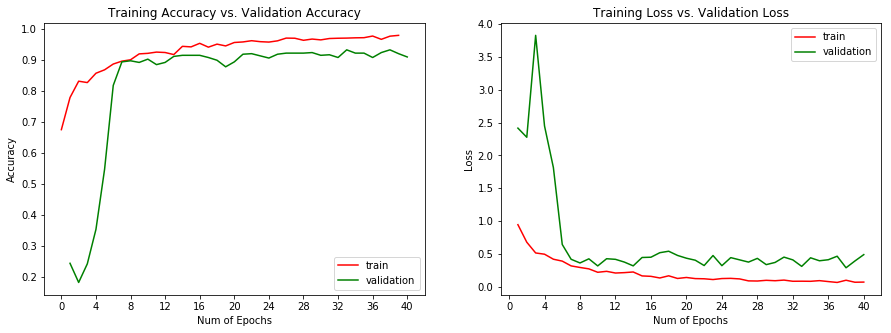

In [19]:
plot_model_history('model_ResNet50', model_ResNet50_info.history, epochs3)

In [0]:
img_width, img_height = 256, 256
test_path = 'unzipped_folder/test/'


test_images = []
test_ids = []
for img in os.listdir(test_path):
    path = os.path.join(test_path, img)
    img_id = img.split('.')[0]
    img = cv2.imread(path)
    img = cv2.resize(img, (img_width, img_height), interpolation = cv2.INTER_CUBIC)
    img = np.reshape(img, (img_width, img_height, 3))
    img = img/255.
    test_images.append(np.array(img))
    test_ids.append(np.array(img_id))


test_images = np.array(test_images)
test_data = test_images.astype('float32')

In [4]:
model_ResNet50 = load_model('drive/My Drive/Colab Notebooks/Models/reset_50_training_sgd02.h5')



Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [0]:
import pandas as pd
submission = pd.DataFrame(model_ResNet50.predict_classes(test_data, verbose=0))
submission.columns = ['flower_class']
submission['id'] = test_ids
submission = submission[['id', 'flower_class']]
submission = submission.sort_values(by=['id'])
submission.to_csv('./submission.csv', index=False)

In [0]:
from google.colab import files
files.download("submission.csv")